# Image classification - transfer learning demo

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
3. [Fine-tuning the Image classification model](#Fine-tuning-the-Image-classification-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Perform Inference](#Perform-Inference)


## Introduction

Welcome to our end-to-end example of distributed image classification algorithm in transfer learning mode. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [15]:
#%%time

## Required Imports  for Estimator from sagemaker package


import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

#################################################################################

role = get_execution_role()
print(role)
print()

# Define a S3 bucket where the data will be stored 
bucket='anshumrsagemaker' # customize to your bucket



# Define the  Algorithm which we want to use and get the container info
#Method 1
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]

#Method 2
training_image1 = get_image_uri(boto3.Session().region_name, 'image-classification', repo_version="latest")


#Same Results 
print(training_image)

arn:aws:iam::011882304826:role/service-role/AmazonSageMaker-ExecutionRole-20180207T172648

685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest


## [Documentation Link ](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) 


The above link has the docker image url for all provided algo in all regions



## Fine-tuning the Image classification model

The CIFAR-10 dataset consist of images from 10 categories and has 50,000 images with 5,000 images per category. 

The image classification algorithm can take two types of input formats. The first is a [recordio format](https://mxnet.incubator.apache.org/tutorials/basic/record_io.html) and the other is a [lst format](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec). Files for both these formats are available at http://data.mxnet.io/data/cifar10/. In this example, we will use the recordio format for training and use the training/validation split.

In [19]:
import os
import urllib.request
import boto3

#Define some healper methods 

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# Download the CIFAR10 Dataset and upload the .rec  taining file and  validation file to S3

download('http://data.mxnet.io/data/cifar10/cifar10_train.rec')
download('http://data.mxnet.io/data/cifar10/cifar10_val.rec')
upload_to_s3('validation/cifar10', 'cifar10_val.rec')
upload_to_s3('train/cifar10', 'cifar10_train.rec')


!aws s3 ls s3://anshumrsagemaker/train/cifar10/
!aws s3 ls s3://anshumrsagemaker/validation/cifar10/

2019-07-12 11:20:10  160200000 cifar10_train.rec
2019-07-12 11:20:09   32040000 cifar10_val.rec


Once we have the data available in the correct format for training, the next step is to actually train the model using the data. Before training the model, we need to setup the training parameters. The next section will explain the parameters in detail.

## Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the "InputDataConfig" section. The main parameters that need to be set is the "ContentType" which can be set to "application/x-recordio" or "application/x-image" based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present. 
* **Output specification**: This is specified in the "OutputDataConfig" section. We just need to specify the path where the output can be stored after training
* **Resource config**: This section specifies the type of instance on which to run the training and the number of hosts used for training. If "InstanceCount" is more than 1, then training can be run in a distributed manner. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 44 in this sample but other values can be used.
* **num_training_samples**: This is the total number of training samples. It is set to 50000 for CIFAR-10 dataset with the current split
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For CIFAR-10, we use 10.
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 10 to 12 minutes per epoch on a p2.xlarge machine. The network typically converges after 10 epochs.  

In [38]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 50
# we need to specify the input image shape for the training data
image_shape = "3,28,28"
# we also need to specify the number of training samples in the training set
# for CIFAR-10 it is 50000
num_training_samples = 50000
# specify the number of output classes
num_classes = 10
# batch size for training
mini_batch_size =  128
# number of epochs
epochs = 10
# learning rate
learning_rate = 0.01
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

# Define training parameters
Run the training using Amazon sagemaker CreateTrainingJob API

In [39]:
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'engineeringLearningseries-cifar10'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/cifar10'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/cifar10'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: engineeringLearningseries-cifar10-2019-07-12-13-10-12

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://anshumrsagemaker/train/cifar10', 'S3DataDistributionType': 'FullyReplicated'}


In [ ]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)



#  Check the  WebUI at this point



# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

In [45]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


If you see the message,

> `Training job ended with status: Completed`

then that means training sucessfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

## Plot training and validation accuracies

Maximum validation accuracy: 0.806991 


<Figure size 432x288 with 0 Axes>

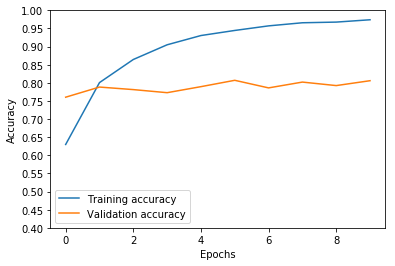

In [46]:
import boto3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

client = boto3.client('logs')

lgn='/aws/sagemaker/TrainingJobs'

# Update this with the actual name in CloudWatch logs
lsn=job_name+'/'+'algo-1-1562937199'
log=client.get_log_events(logGroupName=lgn, logStreamName=lsn)

trn_accs=[]
val_accs=[]
for e in log['events']:
  msg=e['message']
  if 'Validation-accuracy' in msg:
        val = msg.split("=")
        val = val[1]
        val_accs.append(float(val))
  if 'Train-accuracy' in msg:
        trn = msg.split("=")
        trn = trn[1]
        trn_accs.append(float(trn))

print("Maximum validation accuracy: %f " % max(val_accs))
plt.clf()
fig, ax = plt.subplots()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
trn_plot, = ax.plot(range(epochs), trn_accs, label="Training accuracy")
val_plot, = ax.plot(range(epochs), val_accs, label="Validation accuracy")
plt.legend(handles=[trn_plot,val_plot])
ax.yaxis.set_ticks(np.arange(0.4, 1.05, 0.05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()

# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

This section involves several steps,

1. [Create Model](#CreateModel) - Create model for the training output
1. [Create Endpoint Configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create Endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform Inference](#Perform Inference) - Perform inference on some input data using the endpoint.

## Create Model

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [49]:
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="image-classification-transfer-learning"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

image-classification-transfer-learning
s3://anshumrsagemaker/engineeringLearningseries-cifar10/output/engineeringLearningseries-cifar10-2019-07-12-13-10-12/output/model.tar.gz
arn:aws:sagemaker:eu-west-1:011882304826:model/image-classification-transfer-learning


### Create Endpoint Configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [50]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: engineeringLearningseries-cifar10-epc--2019-07-12-13-32-33
Endpoint configuration arn:  arn:aws:sagemaker:eu-west-1:011882304826:endpoint-config/engineeringlearningseries-cifar10-epc--2019-07-12-13-32-33


### Create Endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [51]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: engineeringLearningseries-cifar10-ep--2019-07-12-13-32-37
EndpointArn = arn:aws:sagemaker:eu-west-1:011882304826:endpoint/engineeringlearningseries-cifar10-ep--2019-07-12-13-32-37
CPU times: user 14.6 ms, sys: 0 ns, total: 14.6 ms
Wall time: 154 ms


Finally, now the endpoint can be created. It may take sometime to create the endpoint...

In [52]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

## Perform Inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [53]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

### Download test image

--2019-07-12 13:51:49--  https://cdn.pixabay.com/photo/2014/12/29/15/09/military-raptor-582888_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.141.87, 104.18.82.97, 2606:4700::6812:5261, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.141.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121110 (118K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>] 118.27K  --.-KB/s    in 0.002s  

2019-07-12 13:51:49 (70.8 MB/s) - ‘/tmp/test.jpg’ saved [121110/121110]



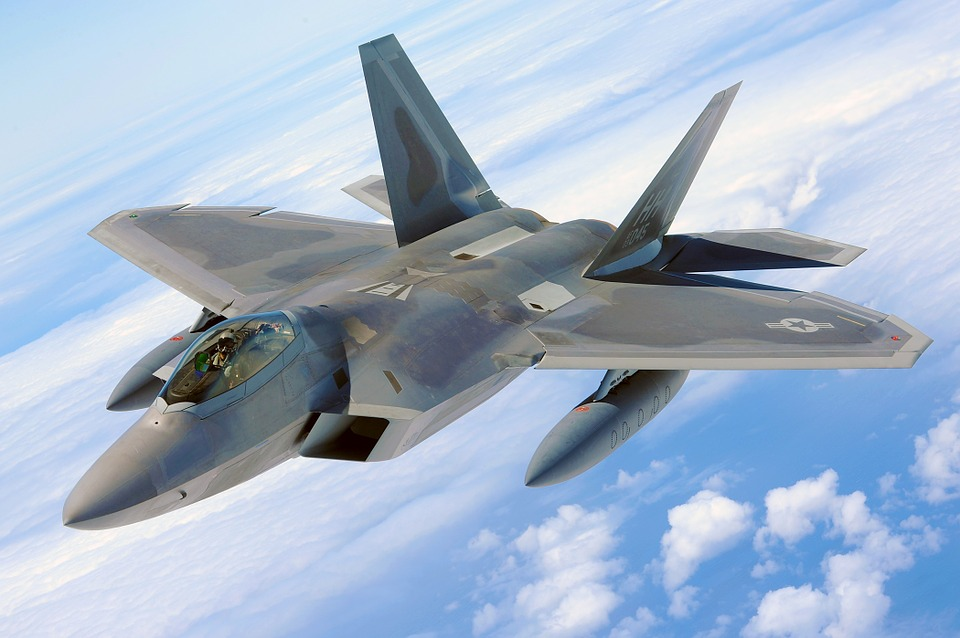

In [71]:
#Horse
#!wget -O /tmp/test.jpg https://cdn.pixabay.com/photo/2013/10/17/20/59/horse-197199_960_720.jpg
#Aeroplane
!wget -O /tmp/test.jpg  https://cdn.pixabay.com/photo/2014/12/29/15/09/military-raptor-582888_960_720.jpg
#!wget -O /tmp/test.jpg  https://cdn.pixabay.com/photo/2019/05/25/16/26/aeroplane-4228685_960_720.jpg
#Truck
#!wget -O /tmp/test.jpg   https://cdn.pixabay.com/photo/2014/11/17/12/15/semi-trailers-534577_960_720.jpg
#!wget -O /tmp/test.jpg   https://cdn.pixabay.com/photo/2019/05/27/17/25/transport-4233202_960_720.png

# Bird
#!wget -O /tmp/test.jpg https://cdn.pixabay.com/photo/2015/12/19/10/54/bird-1099639_960_720.jpg
# Horse
#!wget -O /tmp/test.jpg https://cdn.pixabay.com/photo/2016/02/15/13/26/horse-1201143_960_720.jpg
# Dog
#!wget -O /tmp/test.jpg https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_960_720.jpg
# Truck
#!wget -O /tmp/test.jpg https://cdn.pixabay.com/photo/2015/09/29/10/14/truck-truck-963637_960_720.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [72]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

[0.9995255470275879, 5.878089723410085e-06, 1.4235392882255837e-05, 0.00020889891311526299, 0.00017392029985785484, 8.677180289851094e-07, 1.9062817955273204e-05, 2.8056695100531215e-06, 2.859035703295376e-05, 2.0241510355845094e-05]
Result: label - airplane, probability - 0.9995255470275879


### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
print(endpoint_name)
sage.delete_endpoint(EndpointName=endpoint_name)
sage.delete_endpoint_config(EndpointConfigName=endpoint_name)
sage.delete_model(ModelName=endpoint_name)